In [16]:
# NB requires 190 GB RAM to run!

### Install dependencies

In [1]:
pip install tensorflow scikit-learn pandas matplotlib prettytable --quiet

Note: you may need to restart the kernel to use updated packages.


### Import libraries

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import tensorflow as tf
import pickle
import pandas as pd
import time

from prettytable import PrettyTable

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow import keras
from tensorflow.keras import regularizers
from keras.utils.np_utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical


### Load and split the dataset w. TF-IDF embeddings

In [ ]:
# Load sparse tf-idf data
X_train_sparse, X_test_sparse, y_train_sparse, y_test_sparse, org_train, org_test = pd.read_pickle("pickles/sparse.pkl")

In [4]:
# Split to train and validation sets
X_train_sparse, X_val_sparse, y_train_sparse, y_val_sparse = train_test_split(X_train_sparse, y_train_sparse, test_size=0.2, random_state=42)

### Scaling and encoding

In [5]:
# One-hot encode labels 
encoder = LabelBinarizer()
y_train_enc = encoder.fit_transform(y_train_sparse)
y_val_enc = encoder.transform(y_val_sparse)

# Transform the test set labels using the existing LabelBinarizer
y_test_enc = encoder.transform(y_test_sparse)

In [6]:
# Scale the TFiDF feature vectors
scaler = StandardScaler(with_mean = False)
X_train_scaled = scaler.fit_transform(X_train_sparse)
X_val_scaled = scaler.transform(X_val_sparse)
X_test_scaled = scaler.transform(X_test_sparse)

In [7]:
#Convert X train and X validation csr_matrix into tensors
X_train_tensor = tf.convert_to_tensor(X_train_scaled.toarray())
X_val_tensor = tf.convert_to_tensor(X_val_scaled.toarray())

### Build and train the TF-IDF MLP classifier

In [17]:
model2 = keras.models.Sequential([
    keras.layers.Dense(50, input_shape = (56705,)  , activation = 'relu', kernel_regularizer = regularizers.l2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(100, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(150, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),   
    keras.layers.Dense(6, activation = "softmax")
])

# Compile the model
model2.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ['accuracy'])

# Define the early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

# Train the model with early stopping
%time history = model2.fit(X_train_tensor, y_train_enc, batch_size = 32, epochs = 100, validation_data = (X_val_tensor, y_val_enc), callbacks = [early_stop])

Epoch 1/100
3839/3839 [==============================] - 46s 12ms/step - loss: 2.9213 - accuracy: 0.5546 - val_loss: 2.9496 - val_accuracy: 0.5977
Epoch 2/100
3839/3839 [==============================] - 45s 12ms/step - loss: 2.8102 - accuracy: 0.5995 - val_loss: 2.8712 - val_accuracy: 0.5901
Epoch 3/100
3839/3839 [==============================] - 48s 12ms/step - loss: 2.7799 - accuracy: 0.5974 - val_loss: 2.8313 - val_accuracy: 0.5932
Epoch 4/100
3839/3839 [==============================] - 45s 12ms/step - loss: 2.7045 - accuracy: 0.6035 - val_loss: 2.7562 - val_accuracy: 0.5945
Epoch 5/100
3839/3839 [==============================] - 44s 12ms/step - loss: 2.6318 - accuracy: 0.6046 - val_loss: 2.6556 - val_accuracy: 0.5997
Epoch 6/100
3839/3839 [==============================] - 45s 12ms/step - loss: 2.5705 - accuracy: 0.6077 - val_loss: 2.5709 - val_accuracy: 0.5990
Epoch 7/100
3839/3839 [==============================] - 45s 12ms/step - loss: 2.5034 - accuracy: 0.6102 - val_loss: 2

### Training evaluation

**Loss curve**

960/960 - 3s - loss: 2.2120 - accuracy: 0.6080 - 3s/epoch - 3ms/step


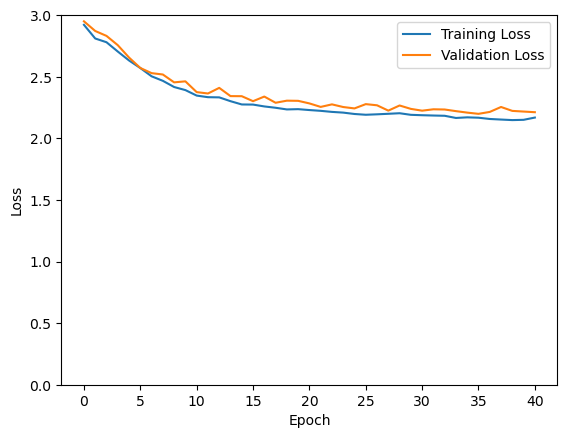

In [ ]:
# Evaluate loss (train vs. val)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])
plt.legend(loc='upper right')

validation_loss, validation_acc = model2.evaluate(X_val_tensor,  y_val_enc, verbose=2)

In [29]:
# Save model 2
pickle.dump(model2, open('MLP_TFIDF.pkl', 'wb'))

In [30]:
# Load model 2
model2 = pd.read_pickle(open('MLP_TFIDF.pkl', 'rb'))

### Predict and evaluate performance on the test set (out-of-sample)

**Predict on the test set**

In [19]:
# Convert X test csr-matrix into tensor 
X_test_tensor = tf.convert_to_tensor(X_test_scaled.toarray())

In [24]:
# Predict the labels for the test set (enc)
y_pred_prob_enc = model2.predict(X_test_tensor)

3571/3571 [==============================] - 13s 4ms/step


In [25]:
# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob_enc, axis=1)
y_test_labels = np.argmax(y_test_enc, axis=1)

**Confusion Matrix**

In [26]:
# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_test_labels, y_pred)

# Create PrettyTable table object
table = PrettyTable()
table.field_names = ["", "Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5"]

# Add the rows to the table
for i in range(len(confusion_mtx)):
    row = ["Class " + str(i)]
    row.extend(confusion_mtx[i])
    table.add_row(row)

# Print the confusion matrix table 
print(table)

+---------+---------+---------+---------+---------+---------+---------+
|         | Class 0 | Class 1 | Class 2 | Class 3 | Class 4 | Class 5 |
+---------+---------+---------+---------+---------+---------+---------+
| Class 0 |  29977  |   2523  |   2021  |   4908  |   1119  |   480   |
| Class 1 |   3475  |  22570  |   1244  |   3428  |   903   |   494   |
| Class 2 |   1066  |   587   |   4127  |   812   |   221   |   305   |
| Class 3 |   4288  |   2104  |   1127  |  15511  |   882   |   286   |
| Class 4 |   1994  |   1198  |   607   |   1835  |   1390  |   463   |
| Class 5 |   255   |   252   |   372   |   254   |   150   |   1043  |
+---------+---------+---------+---------+---------+---------+---------+


**Classification report**

In [27]:
# Generate the classification report
class_report = classification_report(y_test_labels, y_pred, output_dict=True)

# Create the PrettyTable
table = PrettyTable()
table.field_names = ['Class', 'Precision', 'Recall', 'F1-score', 'Support']

# Loop through each class in the classification report and add its metrics to the table
for class_name, metrics in class_report.items():
    if class_name.isnumeric():
        class_id = int(class_name)
        precision = round(metrics['precision'], 2)
        recall = round(metrics['recall'], 2)
        f1_score = round(metrics['f1-score'], 2)
        support = metrics['support']
        table.add_row([class_id, precision, recall, f1_score, support])

# Add the macro and weighted averages to the table
macro_precision = round(class_report['macro avg']['precision'], 2)
macro_recall = round(class_report['macro avg']['recall'], 2)
macro_f1_score = round(class_report['macro avg']['f1-score'], 2)
table.add_row(['macro avg', macro_precision, macro_recall, macro_f1_score, ''])

weighted_precision = round(class_report['weighted avg']['precision'], 2)
weighted_recall = round(class_report['weighted avg']['recall'], 2)
weighted_f1_score = round(class_report['weighted avg']['f1-score'], 2)
table.add_row(['weighted avg', weighted_precision, weighted_recall, weighted_f1_score, ''])

# Print the table
print(table)

+--------------+-----------+--------+----------+---------+
|    Class     | Precision | Recall | F1-score | Support |
+--------------+-----------+--------+----------+---------+
|      0       |    0.73   |  0.73  |   0.73   |  41028  |
|      1       |    0.77   |  0.7   |   0.74   |  32114  |
|      2       |    0.43   |  0.58  |   0.5    |   7118  |
|      3       |    0.58   |  0.64  |   0.61   |  24198  |
|      4       |    0.3    |  0.19  |   0.23   |   7487  |
|      5       |    0.34   |  0.45  |   0.39   |   2326  |
|  macro avg   |    0.53   |  0.55  |   0.53   |         |
| weighted avg |    0.66   |  0.65  |   0.65   |         |
+--------------+-----------+--------+----------+---------+
